# LM Dictionary vs. finbert vs. T5

In [1]:
%config InlineBackend.figure_format='retina'
import logging
import warnings
from ekorpkit import eKonf

logging.basicConfig(level=logging.WARNING)
warnings.filterwarnings('ignore')
print(eKonf.__version__)

0.1.33+30.gbd0c674.dirty


## Prepare `financial_phrasebank` dataset

In [3]:
ds_name = "financial_phrasebank"
cfg = eKonf.compose('dataset/simple=' + ds_name)
cfg.data_dir = '../data/' + ds_name
cfg.io.force.build = True
cfg.io.force.summarize = True
db = eKonf.instantiate(cfg)

apply len_bytes to num_bytes: 100%|██████████| 181/181 [00:00<00:00, 697.31it/s]


In [4]:
ds_cfg = eKonf.compose('dataset')
ds_cfg.name = 'financial_phrasebank'
ds_cfg.path.cache.uri = 'https://github.com/entelecheia/ekorpkit-book/raw/main/assets/data/financial_phrasebank.zip'
ds_cfg.data_dir = ds_cfg.path.cached_path
ds_cfg.verbose = False
ds = eKonf.instantiate(ds_cfg)
print(ds)

Dataset : financial_phrasebank


## Instantiating a sentiment analyser class with `financial_phrasebank` dataset

In [5]:
model_cfg = eKonf.compose('model/sentiment=lm')

cfg = eKonf.compose(config_group='pipeline')
cfg.verbose = False
cfg.data.dataset = ds_cfg
cfg._pipeline_ = ['predict']
cfg.predict.model = model_cfg
cfg.predict.output_dir = "../data/predict"
cfg.predict.output_file = f'{ds_cfg.name}.parquet'
cfg.num_workers = 1
df = eKonf.instantiate(cfg)
df

Predicting [text]:   0%|          | 0/1445 [00:00<?, ?it/s]

Predicting [text]:   0%|          | 0/452 [00:00<?, ?it/s]

Predicting [text]:   0%|          | 0/362 [00:00<?, ?it/s]

{'train':          id                                               text    labels  \
 index                                                                      
 0       655  Customers in a wide range of industries use ou...   neutral   
 1       634  The writing and publication of Lemmink+ñinen -...   neutral   
 2      1030  Sullivan said some of the boards `` really inv...   neutral   
 3       317  The six breweries recorded a 5.2 percent growt...  positive   
 4       868  In the second quarter of 2010 , the company 's...  positive   
 ...     ...                                                ...       ...   
 1440    136  In the fourth quarter of 2009 , Orion 's net p...  positive   
 1441   2170  Profit for the period totalled EUR 1.1 mn , do...  negative   
 1442    344  The diluted loss per share narrowed to EUR 0.2...  positive   
 1443    573  LKAB , headquartered in Lulea , Sweden , is a ...   neutral   
 1444   1768  The EBRD is using its own funds to provide a 2...   n

In [6]:
print(cfg.predict.output_dir)
print(cfg.predict.output_file)

../data/predict
financial_phrasebank.parquet


In [12]:
tmp_df = eKonf.load_data("financial_phrasebank-dev.parquet", cfg.predict.output_dir)

In [19]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              362 non-null    int64  
 1   text            362 non-null    object 
 2   labels          362 non-null    object 
 3   subset          362 non-null    object 
 4   split           362 non-null    object 
 5   num_tokens      360 non-null    float64
 6   polarity        360 non-null    float64
 7   polarity_label  360 non-null    object 
 8   uncertainty     360 non-null    float64
dtypes: float64(3), int64(1), object(5)
memory usage: 25.6+ KB


Accuracy:  0.6421895861148198
Precison:  0.6333030880769485
Recall:  0.6421895861148198
F1 Score:  0.5974587783784485
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

    negative       0.39      0.36      0.37       302
     neutral       0.68      0.89      0.77      1375
    positive       0.65      0.19      0.29       570

    accuracy                           0.64      2247
   macro avg       0.57      0.48      0.48      2247
weighted avg       0.63      0.64      0.60      2247



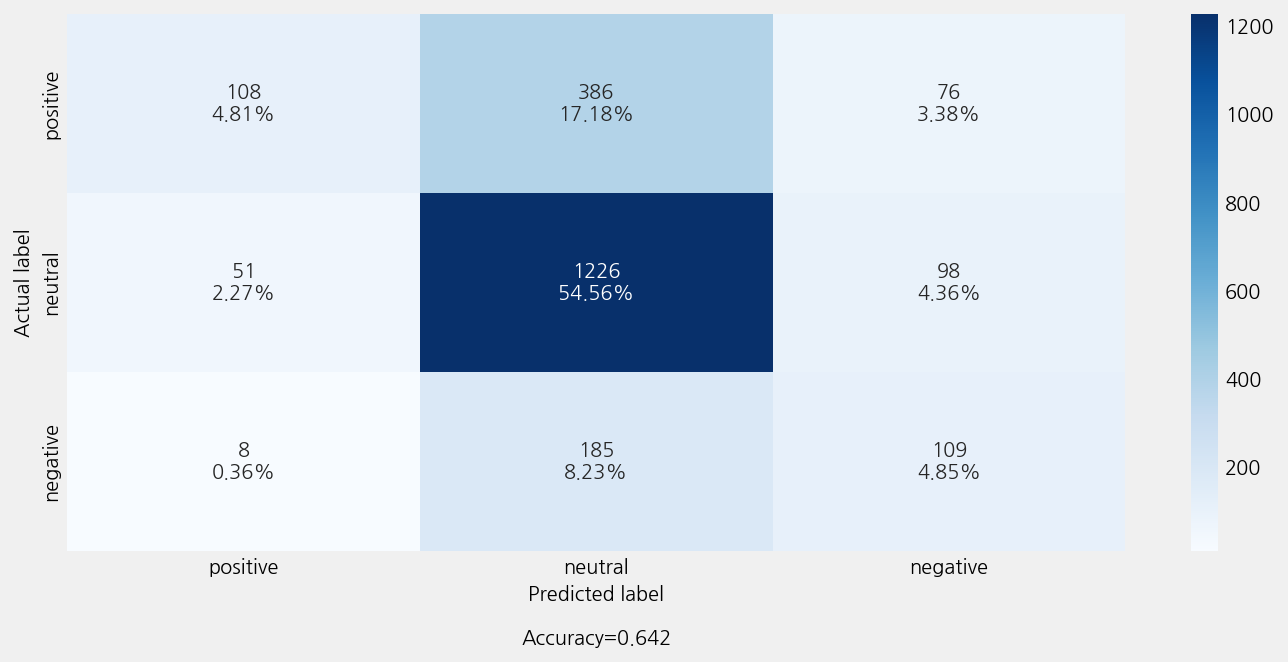

In [3]:
eval_cfg = eKonf.compose('model/eval=classification')
eval_cfg.columns.actual = 'labels'
eval_cfg.columns.predicted = 'polarity_label'
eval_cfg.labels = ['positive','neutral','negative']
eval_cfg.data_dir = '../data/predict'
eval_cfg.data_file = 'financial_phrasebank-*.parquet'
eval_cfg.output_dir = '../data/eval'
eKonf.instantiate(eval_cfg)

## Instantiating a transformer classficiation model with `financial_phrasebank` dataset

In [3]:
overrides=[
    '+model/transformer=classification',
    '+model/transformer/pretrained=finbert',
]
model_cfg = eKonf.compose('model/transformer=classification', overrides)
model_cfg.dataset = ds_cfg
model_cfg.verbose = False
model_cfg.config.num_train_epochs = 2
model_cfg.config.max_seq_length = 256
model_cfg.config.train_batch_size = 32
model_cfg.config.eval_batch_size = 32
model_cfg.labels = ['positive','neutral','negative']
model_cfg._method_ = ['train']
eKonf.instantiate(model_cfg)

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

  0%|          | 0/1445 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

wandb: Currently logged in as: entelecheia. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Epoch 0 of 2:   0%|          | 0/46 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/452 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Training loss,▁
acc,▁█
eval_loss,█▁
global_step,▁▂█
lr,▁
mcc,▁█
train_loss,█▁
Training loss,0.5406
acc,0.91436
eval_loss,0.29525
global_step,92


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/452 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy:  0.9004424778761062
Precison:  0.9067742606459421
Recall:  0.9004424778761062
F1 Score:  0.90187372379709
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

    negative       0.94      0.80      0.87        61
     neutral       0.96      0.93      0.94       277
    positive       0.77      0.88      0.82       114

    accuracy                           0.90       452
   macro avg       0.89      0.87      0.88       452
weighted avg       0.91      0.90      0.90       452



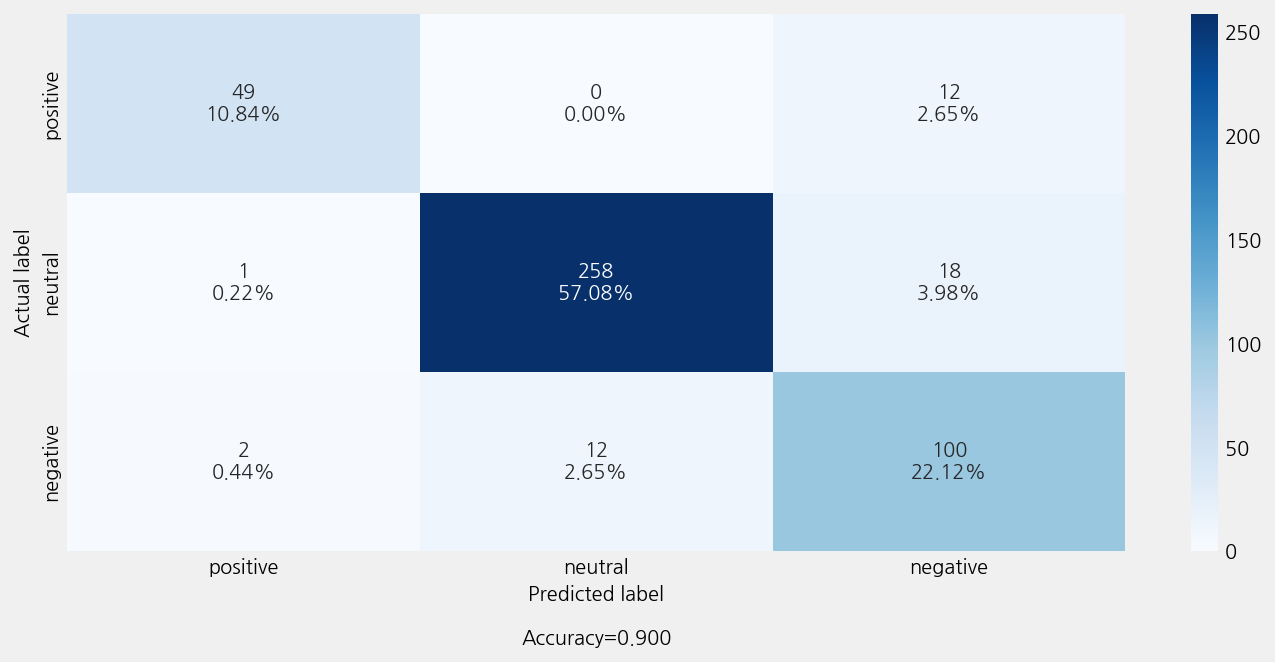

In [5]:
overrides=[
    '+model/transformer=classification',
    '+model/transformer/pretrained=finbert',
]
model_cfg = eKonf.compose('model/transformer=classification', overrides)
model_cfg.dataset = ds_cfg
model_cfg.verbose = False
model_cfg.config.num_train_epochs = 2
model_cfg.config.max_seq_length = 256
model_cfg.config.train_batch_size = 32
model_cfg.config.eval_batch_size = 32
model_cfg.labels = ['positive','neutral','negative']
model_cfg._method_ = ['eval']
eKonf.instantiate(model_cfg)

## Instantiating a T5 classficiation model with `financial_phrasebank` dataset

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

  0%|          | 0/1445 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Epoch 0 of 2:   0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

  0%|          | 0/452 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.07960319360503681}


Generating outputs:   0%|          | 0/57 [00:00<?, ?it/s]

Accuracy:  0.9402654867256637
Precison:  0.9406832105947149
Recall:  0.9402654867256637
F1 Score:  0.9395622196129697
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

    negative       0.96      0.82      0.88        61
     neutral       0.94      0.97      0.96       277
    positive       0.93      0.93      0.93       114

    accuracy                           0.94       452
   macro avg       0.94      0.91      0.92       452
weighted avg       0.94      0.94      0.94       452



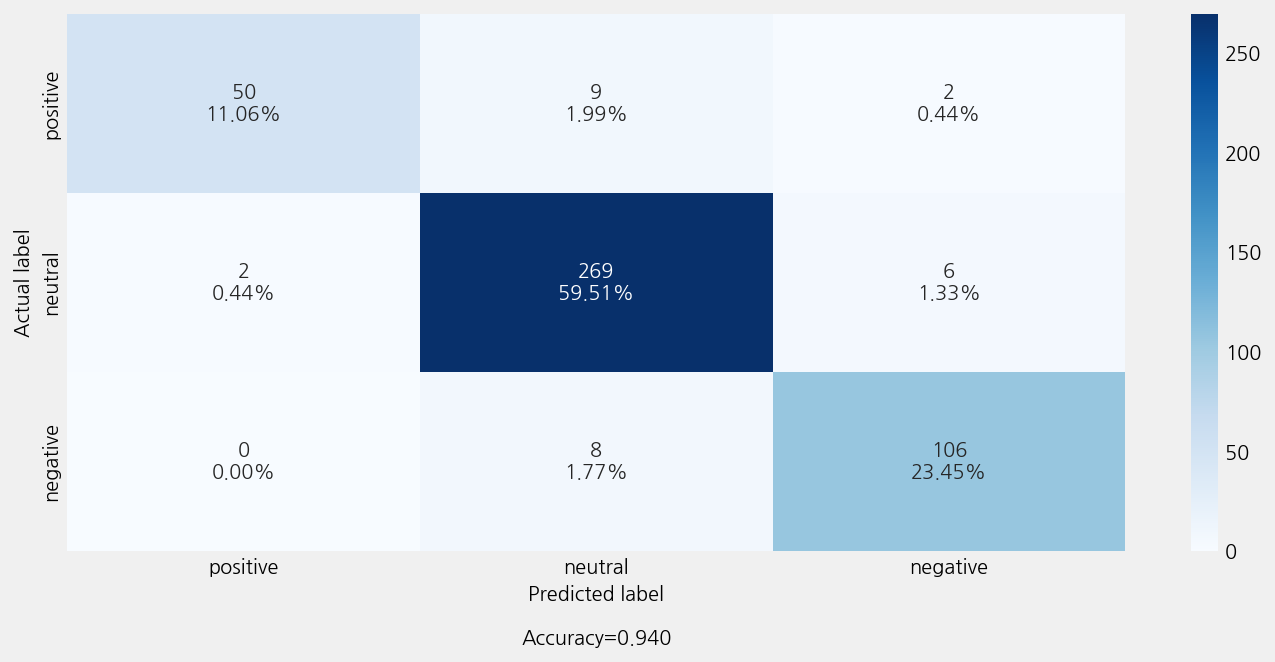

In [6]:
overrides=[
    '+model/transformer=t5_classification_with_simple',
    '+model/transformer/pretrained=t5-base',
]
model_cfg = eKonf.compose('model/transformer=t5_classification_with_simple', overrides)
model_cfg.dataset = ds_cfg
model_cfg.verbose = False
model_cfg.config.num_train_epochs = 2
model_cfg.config.max_seq_length = 256
model_cfg.config.train_batch_size = 8
model_cfg.config.eval_batch_size = 8
model_cfg.labels = ['positive','neutral','negative']
model_cfg._method_ = ['train', 'eval']
# model_cfg._method_ = ['eval']
eKonf.instantiate(model_cfg)